# Combined Deep Q-Network (DQN) for LunarLander-v2

This notebook is an implementation of a Combined Deep Q-Network (Double & Noisy) to tackle the "LunarLander-v2" environment in OpenAI Gym. The Combined DQN will learn to land a spacecraft safely on the lunar surface. The goal is to achieve an average score of 195 or above over the last 50 episodes.

## Import Libraries

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import os
import renderlab
import itertools
from torch.nn.init import uniform_
import math

## Setting Up the Environment

Initializing the LunarLander-v2 environment and determining the state and action sizes.

In [ ]:
# Initialize the Lunar Lander environment
env = gym.make('LunarLander-v2')
# Get the size of the state space from the environment
state_size = env.observation_space.shape[0]  
# Get the number of actions available from the environment
action_size = env.action_space.n  

## Defining Hyperparameters and Variables

In [2]:
# Define the Parameters

# Discount factor for future rewards
GAMMA = 0.99  
# Size of the batch used in learning
BATCH_SIZE = 128 
# Maximum size of the replay buffer
BUFFER_SIZE = 10000  
# Starting value of epsilon for the epsilon-greedy policy
EPS_START = 1.0 
# Minimum value of epsilon for the epsilon-greedy policy
EPS_END = 0.01
# Decay rate of epsilon per episode
EPS_DECAY = 0.995  
# Learning rate for the neural network optimizer
LEARNING_RATE = 0.0005  

# Define the Variables

# Threshold score for considering the environment solved
solved_score = 195
# List to keep track of total reward per episode
scores = []  
# List to keep track of average score over the last 50 episodes
average_scores = []  
# Maximum steps per episode to prevent very long episodes
max_steps_per_episode = 2000 
# Flag to indicate whether the environment is solved
solved = False 

## Setting Up Model Saving Paths

Defining and preparing the file paths for saving the trained model and average score data. 

In [3]:
# Define the path where the trained model will be saved
model_save_path = 'models/combined_dqn_lunarlander_model.pth'

# Extract the directory path from the model save path
model_directory = os.path.dirname(model_save_path)
# Check if the directory exists
if not os.path.exists(model_directory):
    # If the directory does not exist, create it
    os.makedirs(model_directory)
    
# Define the path for saving average score data
folder_path = 'average_scores/'

# Check if the directory for average scores exists
if not os.path.exists(folder_path):
    # If the directory does not exist, create it
    os.makedirs(folder_path)

## Defining the NoisyLinear Layer

Constructing the `NoisyLinear` class, a variant of the linear layer that introduces randomness into its weights and biases. This class enhances exploration in the Noisy DQN model by adding noise during training, while using deterministic weights during evaluation.

In [4]:
class NoisyLinear(nn.Module):
    def __init__(self, in_size, out_size):
        super(NoisyLinear, self).__init__()

        # Initialize the mean (mu) and standard deviation (sigma) for the weights
        self.w_mu = nn.Parameter(torch.empty((out_size, in_size)))
        self.w_sigma = nn.Parameter(torch.empty((out_size, in_size)))

        # Initialize the mean (mu) and standard deviation (sigma) for the biases
        self.b_mu = nn.Parameter(torch.empty((out_size)))
        self.b_sigma = nn.Parameter(torch.empty((out_size)))

        # Uniformly initialize the mean parameters
        uniform_(self.w_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))
        uniform_(self.b_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))

        # Initialize the sigma parameters with a constant value
        nn.init.constant_(self.w_sigma, 0.017)
        nn.init.constant_(self.b_sigma, 0.017)

    def forward(self, x, sigma=1):
        # During training, add noise to the weights and biases
        if self.training:
            # Generate random noise for weights and biases
            w_noise = torch.normal(0, sigma, size=self.w_mu.size())
            b_noise = torch.normal(0, sigma, size=self.b_mu.size())

            # Apply noisy linear transformation
            return F.linear(x, self.w_mu + self.w_sigma * w_noise, self.b_mu + self.b_sigma * b_noise)
        else:
            # During evaluation, use the mean values without noise
            return F.linear(x, self.w_mu, self.b_mu)

## Defining the Combined DQN Model

Defining the neural network architecture for the Combined DQN agent

In [5]:
# Combined DQN Model
class COMBINED_DQN(nn.Module):
    # The constructor of the COMBINED_DQN class, inheriting from nn.Module
    def __init__(self, state_size, action_size):
        super(COMBINED_DQN, self).__init__()
        # Initialize the first fully connected layer with noise
        self.fc1 = NoisyLinear(state_size, 64)
        # Initialize the second fully connected layer with noise
        self.fc2 = NoisyLinear(64, 64)
        # Initialize the third fully connected layer with noise
        # This layer outputs Q-values for each action
        self.fc3 = NoisyLinear(64, action_size)

    def forward(self, x):
        # Pass input through the first noisy linear layer and apply ReLU activation
        x = F.relu(self.fc1(x))
        # Pass through the second noisy linear layer and apply ReLU activation
        x = F.relu(self.fc2(x))
        # Pass through the final noisy linear layer to get Q-values for each action
        return self.fc3(x)

## Implementing Replay Memory

Implementing a replay buffer to store and sample experiences for training the Combined DQN agent.

In [6]:
# Define a namedtuple to store the experience tuples
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    # Constructor for ReplayMemory class
    def __init__(self, capacity):
        # Initialize a double-ended queue with a fixed maximum size (capacity)
        # This deque will store the transitions
        self.memory = deque([], maxlen=capacity)

    # Method to push a new transition into the memory
    def push(self, *args):
        self.memory.append(Transition(*args))

    # Method to randomly sample a batch of transitions from the memory
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    # Method to return the length of the memory
    def __len__(self):
        return len(self.memory)

## Creating the Combined DQN Agent (Double & Noisy)

Creating a class for the Combined DQN agent encapsulating action selection, model updates, and interaction with replay memory.

In [7]:
# DQN Agent with Combined Double DQN and Noisy DQN Features
class Combined_DQNAgent:
    # Constructor for initializing the agent
    def __init__(self, state_size, action_size):
        # Store state and action dimensions
        self.state_size = state_size
        self.action_size = action_size
        # Initialize epsilon for epsilon-greedy action selection
        self.epsilon = EPS_START

        # Initialize policy network with combined DQN architecture
        self.policy_net = COMBINED_DQN(state_size, action_size)
        # Initialize target network (for stable Q-targets) with same architecture
        self.target_net = COMBINED_DQN(state_size, action_size)
        # Copy weights from policy network to target network
        self.target_net.load_state_dict(self.policy_net.state_dict())
        # Set target network to evaluation mode (no training)
        self.target_net.eval()

        # Optimizer for policy network
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        # Replay memory for storing experiences
        self.memory = ReplayMemory(BUFFER_SIZE)

    # Method to select an action based on current state
    def select_action(self, state):
        # Epsilon-greedy action selection
        if random.random() > self.epsilon:
            # Choose the best action from policy network (exploitation)
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            # Choose a random action (exploration)
            return torch.tensor([[random.randrange(self.action_size)]], dtype=torch.long)

    # Method to optimize the model
    def optimize_model(self):
        # Return if not enough samples in the memory
        if len(self.memory) < BATCH_SIZE:
            return

        # Sample a batch of transitions from memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # Separate non-final and final next states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, dtype=torch.float32)

        # Compute current Q values using policy network
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Double DQN logic for stable Q targets
        next_state_actions = self.policy_net(non_final_next_states).max(1)[1].unsqueeze(1)
        next_state_values = torch.zeros(BATCH_SIZE)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).gather(1, next_state_actions).squeeze(1)
        
        # Compute expected Q values using target Q values and immediate rewards
        expected_state_action_values = (next_state_values * GAMMA) * (1 - done_batch) + reward_batch

        # Compute loss and perform backpropagation
        loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    # Method to update target network weights
    def update_target_net(self):
        # Copy weights from policy network to target network
        self.target_net.load_state_dict(self.policy_net.state_dict())

    # Method to decay epsilon for epsilon-greedy strategy
    def decay_epsilon(self):
        # Reduce epsilon value, but not below minimum threshold
        self.epsilon = max(EPS_END, EPS_DECAY * self.epsilon)
        

# Instantiate a the Combined DQN agent with state and action sizes
agent = Combined_DQNAgent(state_size, action_size)

## The Training Loop

Running the training process for the agent, including interacting with the environment, optimizing the model, and tracking progress.

In [8]:
# Initialize the Lunar Lander environment
env = gym.make('LunarLander-v2')
# Get the size of the state space from the environment
state_size = env.observation_space.shape[0]  
# Get the number of actions available from the environment
action_size = env.action_space.n  

# Instantiate a Noisy DQN agent with state and action sizes
agent = Combined_DQNAgent(state_size, action_size)

# Wrap the episode range with tqdm for the progress bar
for i_episode in itertools.count():
    state_tuple = env.reset()
    state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
    state = torch.from_numpy(state).float().unsqueeze(0)
    total_reward = 0
    done = False
    step_count = 0  # Step counter for each episode

    while not done and step_count < max_steps_per_episode:
        action = agent.select_action(state)
        output = env.step(action.item())
        next_state = output[0]
        reward = output[1]
        done = output[2]

        next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        reward_tensor = torch.tensor([reward], dtype=torch.float)

        agent.memory.push(state, action, next_state, reward_tensor, done)
        state = next_state
        total_reward += reward
        agent.optimize_model()

        step_count += 1

    agent.update_target_net()
    agent.decay_epsilon()
    scores.append(total_reward)

    # Calculate average score of the last 50 episodes
    if len(scores) >= 50:
        avg_score_last_50 = np.mean(scores[-50:])
        average_scores.append(avg_score_last_50)

        # Check if the environment is solved
        if avg_score_last_50 >= solved_score and not solved:
            print("*"*125)
            print(f"Solved at episode: {i_episode} - Average score over the last 50 episodes: {avg_score_last_50}")
            torch.save(agent.policy_net.state_dict(), model_save_path)
            print("*"*125)
            print(f"Model successfully saved to {model_save_path}")
            solved = True
            break  # Stop training since the environment is considered solved

    # Output progress every 10 episodes
    if i_episode % 10 == 0:
        # Calculate the average of the last 10 episodes
        avg_score_last_10 = np.mean(scores[-10:])
        print(f"Episode {i_episode}, Average Score Last 10 Episodes: {avg_score_last_10}")
    
# Save the file
np.save(folder_path + 'average_scores_combined.npy', average_scores)  

env.close()

Episode 0, Average Score Last 10 Episodes: 3.817904720304753
Episode 10, Average Score Last 10 Episodes: -153.62970182929402
Episode 20, Average Score Last 10 Episodes: -149.5108071028464
Episode 30, Average Score Last 10 Episodes: -163.7208676229824
Episode 40, Average Score Last 10 Episodes: -143.2499634963047
*****************************************************************************************************************************
Solved at episode: 49 - Average score over the last 50 episodes: -139.66570571293153
*****************************************************************************************************************************
Model successfully saved to models/combined_dqn_lunarlander_model.pth


## Training Progress Visualization

Visualizing the training progress with a plot of the average reward per episode (Y-axis) against the number of episodes (X-axis).

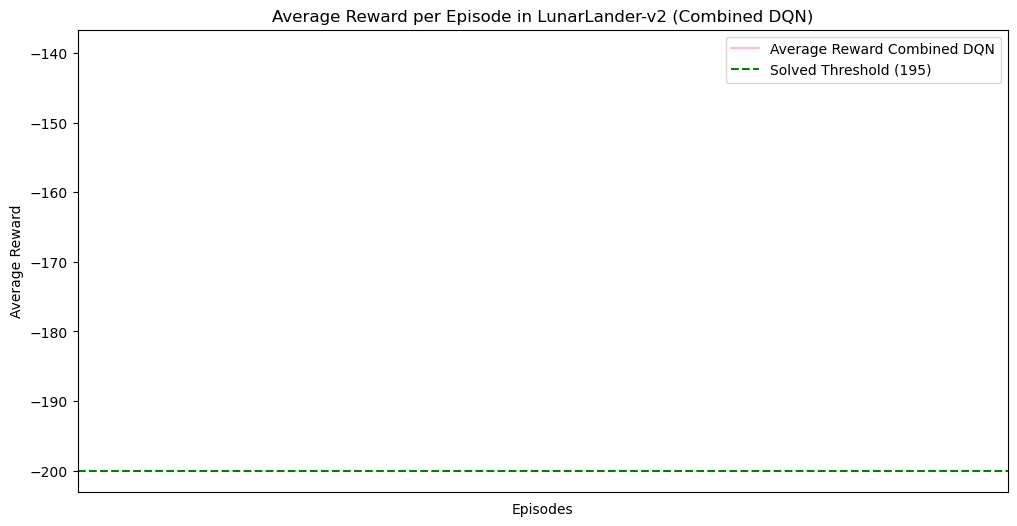

In [9]:
# Creating the plot

# Generate a range of episode numbers for the x-axis
# Start from episode 10 and increment by 10 until the number of episodes recorded
episode_numbers = list(range(10, len(average_scores) * 10 + 1, 10))

plt.figure(figsize=(12, 6))

# Plot average rewards per episode
plt.plot(episode_numbers, average_scores, label='Average Reward Combined DQN', color='Pink')

# Add a horizontal line representing the solved threshold
plt.axhline(y=solved_score, color='green', linestyle='--', label='Solved Threshold (195)')

# Set x-axis labels to show every 100 episodes
plt.xticks(range(0, len(average_scores) + 1, 100))

# Set labels for x and y axes
plt.xlabel('Episodes')
plt.ylabel('Average Reward')

# Display the plot
plt.title('Average Reward per Episode in LunarLander-v2 (Combined DQN)')
plt.legend()
plt.show()